In [1]:
from SALib.analyze import morris
import numpy as np
import pandas as pd
import re, os
import time
import matplotlib.pyplot as plt
from adjustText import adjust_text

Colorblind-friendly palette

In [2]:
plt.style.use('tableau-colorblind10')

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [3]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [4]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


BRICK parameters are the same for all scenarios because they are calibrated in hindcast.

In [5]:
brickdir = "https://zenodo.org/record/6626335/files/parameters_subsample_sneasybrick.csv"
dfPB = pd.read_csv(brickdir)

SSP-RCP scenarios and a dictionary to hold the sensitivity results from Method of Morris:

In [6]:
surge_option = 0
scenarios = [(1,26),(2,45),(4,60),(5,85)]
dfSi = {scen : None for scen in scenarios}

Directories where all the BRICK-CIAM results are, for all the different SSP-RCP scenarios.

In [7]:
def subtract_ref_npv(dfO,dfG):
    nens = dfO.ens.max()
    npv_ref = np.zeros(nens)
    df1 = dfO.loc[dfO.time==1]
    for i in range(1,nens+1):
        # first 10 of the first timestep for a single ensemble member are OptimalCost
        # *10 to account for 10-year timestep vs annual costs
        npv_ref[i-1] = np.sum(np.array(df1.loc[df1.ens==i,"cost"])[:10])*10
    dfG.npv = dfG.npv - npv_ref
    return dfG

In [11]:
for (ssp, rcp) in scenarios:
    bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
    dfSC = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfO = pd.read_csv(bothdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfSC = subtract_ref_npv(dfO,dfSC)

    dfR = pd.read_csv(bothdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfO = pd.read_csv(bothdir+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfR = dfR - dfO
    dfSC.join(dfR)
    
    dfPC = pd.read_csv(bothdir+"/trials_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv",
                       names = ["movefactor","dvbm","vslel","vslmult","wvel","wvpdl"], header=0)

    tmp = dfPB.iloc[dfSC.brickEnsInd]
    tmp.reset_index(inplace=True, drop=True)
    dfP = pd.concat([tmp,dfPC], axis=1)
        
    n_ensemble, n_parameter = dfP.shape
    mins = list(dfP.min())
    maxs = list(dfP.max())
    bounds = [[mins[i],maxs[i]] for i in range(n_parameter)]

    problem = {"num_vars" : n_parameter,
               "names" : list(dfP.columns),
               "bounds" : bounds}

    X = np.array(dfP)[:986,:]
    Y = np.array(dfSC.npv)[:986]
    #dfSi[(ssp,rcp)] = pd.DataFrame(SALib.analyze.morris.analyze(problem, X, Y, print_to_console=False))
    dfSi[(ssp,rcp)] = pd.DataFrame(morris.analyze(problem, X, Y, print_to_console=False))
    dfSi[(ssp,rcp)]["dist"] = np.sqrt(dfSi[(ssp,rcp)].mu_star**2 + dfSi[(ssp,rcp)].sigma**2)
    

In [17]:
ciam_params = list(dfPC.columns)

* dvbm = FUND value of OECD dryland per Darwin et al 1995 converted from $1995 ($2010M per sqkm) (5.376)
* wvel = income elasticity of wetland value (1.16) (Brander et al, 2006)
* movefactor = Cost to relocate mobile capital as a fraction of asset value (0.1)
* vslel = Elasticity of vsl (0.5) (only used for endogenous calculation of vsl)
* vslmult = multiplier on USA GDP (216)(only used for endogenous calculation of vsl)
* wvpdl = Population density elasticity of wetland value (0.47) (Brander et al, 2

### sorted by mu_star

In [12]:
top = 8
for scen in scenarios:
    print("================================")
    print(scen)
    print(dfSi[scen].sort_values(by="mu_star", ascending=False)[["names","mu_star","sigma"]][:top])

(1, 26)
                       names       mu_star        sigma
52                      dvbm  18637.168073  4834.048759
55                      wvel   6170.062661  3632.611012
56                     wvpdl   4775.331209  5249.469538
54                   vslmult   4526.187187  4174.815794
8             rho_ocean_heat   4445.370006  5254.013307
50  antarctic_temp_threshold   4434.140893  5343.844663
7            rho_temperature   4415.537145  5468.599606
47     antarctic_bed_height0   4412.548741  5630.719060
(2, 45)
                names       mu_star         sigma
52               dvbm  24812.939380   8223.894791
55               wvel  15473.774112   8155.706067
36         anto_alpha   9322.513204  11330.668225
12           rho_gmsl   8694.465661  11132.788641
42  antarctic_precip0   8569.216302  11364.180102
48    antarctic_slope   8467.130837   9863.920049
32    greenland_alpha   8374.461811  10028.762398
51         movefactor   8247.856336  10923.857790
(4, 60)
              names   

### sorted by distance (mustar^2 + sigma^2)

In [13]:
top = 8
for scen in scenarios:
    print("================================")
    print(scen)
    print(dfSi[scen].sort_values(by="dist", ascending=False)[["names","mu_star","sigma","dist"]][:top])

(1, 26)
                       names       mu_star        sigma          dist
52                      dvbm  18637.168073  4834.048759  19253.884314
55                      wvel   6170.062661  3632.611012   7159.995531
47     antarctic_bed_height0   4412.548741  5630.719060   7153.711171
30               greenland_a   4327.640598  5674.211343   7136.185782
56                     wvpdl   4775.331209  5249.469538   7096.528630
7            rho_temperature   4415.537145  5468.599606   7028.694753
50  antarctic_temp_threshold   4434.140893  5343.844663   6943.938453
8             rho_ocean_heat   4445.370006  5254.013307   6882.293972
(2, 45)
                names       mu_star         sigma          dist
52               dvbm  24812.939380   8223.894791  26140.283208
55               wvel  15473.774112   8155.706067  17491.518708
36         anto_alpha   9322.513204  11330.668225  14672.876162
42  antarctic_precip0   8569.216302  11364.180102  14232.921606
12           rho_gmsl   8694.46566

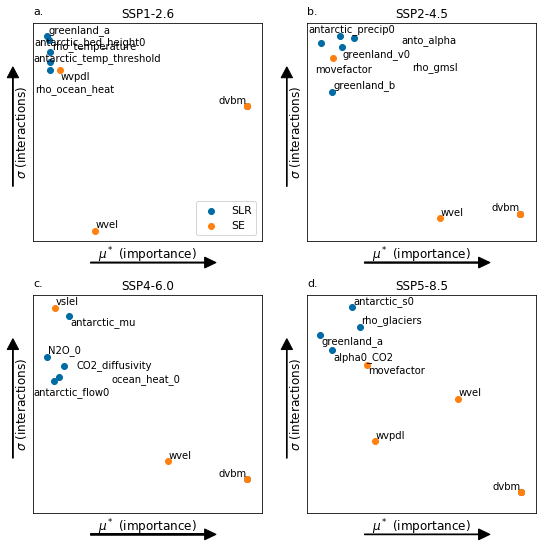

In [19]:
#top = len(dfSi[(1,26)])
top = 8
scen_labels = ["SSP1-2.6","SSP2-4.5","SSP4-6.0","SSP5-8.5"]
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]
colors = {"SLR":"C0", "SE":"C1"}

fig, ax = plt.subplots(2,2,figsize=(9,9))
fig.subplots_adjust(hspace=.25,wspace=0.2)
for s in range(len(scenarios)):
    scen = scenarios[s]
    row,col = int(s/2), s%2
    names  = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["names"])
    mustar = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["mu_star"])
    sigma  = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["sigma"])
    # for the legend only
    ax[row][col].scatter(np.log10(mustar[0]),np.log10(sigma[0]),color=colors["SLR"],label="SLR")
    ax[row][col].scatter(np.log10(mustar[0]),np.log10(sigma[0]),color=colors["SE"],label="SE")
    for i in range(top):
        color = colors["SE"] if (names[i] in ciam_params) else colors["SLR"]
        ax[row][col].scatter(np.log10(mustar[i]),np.log10(sigma[i]), color=color)
    ax[row][col].set_title(scen_labels[s], fontsize=12);
    ax[row][col].set_xticks([]); ax[row][col].set_yticks([])
    xlims = ax[row][col].get_xlim(); xrange = np.diff(xlims)[0]
    ylims = ax[row][col].get_ylim(); yrange = np.diff(ylims)[0]
    ax[row][col].text(xlims[0], ylims[1]+0.04*yrange, panels[s], fontsize=11)
    annotations = []
    for i in range(top):
        annotations.append(ax[row][col].text(np.log10(mustar[i]),np.log10(sigma[i]),names[i]))
    adjust_text(annotations,x=np.log10(mustar),y=np.log10(sigma),ax=ax[row][col],expand_align=(1.2,1.2))
    
    bbox_props = dict(boxstyle="rarrow, pad=0.2", fc="white", ec="black", lw=1)
    ax[row][col].set_xlabel("$\\mu^*$ (importance)", fontsize=12);
    ax[row][col].set_ylabel("$\\sigma$ (interactions)", fontsize=12);
    ax[row][col].arrow(xlims[0]+0.25*xrange, ylims[0]-0.1*yrange, 0.5*xrange, 0,
                       head_width=0.05*yrange, head_length=0.05*xrange, fc='k', ec='k', clip_on=False)
    ax[row][col].arrow(xlims[0]-0.09*xrange, ylims[0]+0.25*yrange, 0, 0.5*yrange,
                       head_width=0.05*xrange, head_length=0.05*yrange, fc='k', ec='k', clip_on=False)
    if s==0:
        ax[row][col].legend(fontsize=11,loc="lower right")
fig.savefig(plotdir+"/sensitivity_ssprcp.pdf", bbox_inches='tight');
